# Prepare COVID data for US counties

In [1]:
%matplotlib inline

import geopandas
import pandas

## County boundaries

- Pull counties

In [2]:
county_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip"
counties = geopandas.read_file(county_url)
counties["fips"] = counties["STATEFP"] + counties["COUNTYFP"]

- Simplify table

In [3]:
tokeep = ["GEOID", "fips", "geometry"]
counties_slim = counties[tokeep]

## COVID-19 figures

- Pull down data

In [4]:
covid_url = "https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv"
covid = pandas.read_csv(covid_url)

- Remove entries without FIPS codes

In [5]:
covid_w_fips = covid.dropna()

- Keep only newer than March 15th

In [6]:
recent_covid_w_fips = covid_w_fips.assign(pdate=pandas.to_datetime(covid_w_fips["date"]))\
                                  .query("pdate > 'March 25th 2020'")

- Index on everything but counts and widen by date

In [7]:
db = recent_covid_w_fips.set_index(["fips", "county", "state", "date"])\
                        .unstack()

Example of cases for the top ten counties on April 17th:

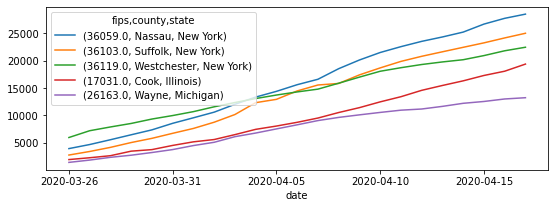

In [8]:
db["cases"]\
  .sort_values("2020-04-17", ascending=False)\
  .head()\
  .T\
  .plot(figsize=(9, 3))

- Clean FIPS

In [9]:
db_clean = db.reset_index()
db_clean["fips"] = db_clean["fips"].astype(int)\
                                   .astype(str)\
                                   .apply(lambda i: i.zfill(5))
db_clean = db_clean.set_index("fips") 

## Single datasets (cases and deaths)

- Join, keep only geoms with COVID data and write out to single file

In [10]:
for d in ["cases", "deaths"]:
    f_path = f"covid_county_{d}.gpkg"
    print(f"Preparing {f_path}")
    # Keep geoms w/ any COVID data
    gdb_all = counties_slim.join(db_clean[d].assign(county=db_clean[("county", "")]), 
                                 on="fips"
                                )
    gdb_all = gdb_all.reindex(gdb_all[gdb_all["county"].notnull()].index)
    # Retain continental counties only
    gdb_all = gdb_all.cx[-130:, :50]
    # Write to GPKG
    gdb_all.to_file(f_path, driver="GPKG")

Preparing covid_county_cases.gpkg
Preparing covid_county_deaths.gpkg
